# Recommendation Systems Assignment

### MIE 1513 UofT

### Imports

In [149]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Support functions and variables

In [150]:
wget.download("https://github.com/MIE1513HS-2022/course-datasets/raw/main/ml-100k.zip", "ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [151]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [152]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [153]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [154]:
rating_df_train = getData(MOVIELENS_DIR, 'u1.base')
rating_df_test = getData(MOVIELENS_DIR, 'u1.test')

In [155]:
rating_df_train.head()

,userID,itemID,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [156]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [157]:
print("Number of users in rating df:", len(rating_df.userID.unique()))
print("Number of items in rating df:", len(rating_df.itemID.unique()))
print("Number of users in train df:", len(rating_df_train.userID.unique()))
print("Number of items in train df:", len(rating_df_train.itemID.unique()))
print("Number of users in test df:", len(rating_df_test.userID.unique()))
print("Number of items in test df:", len(rating_df_test.itemID.unique()))

Number of users in rating df: 943
Number of items in rating df: 1682
Number of users in train df: 943
Number of items in train df: 1650
Number of users in test df: 459
Number of items in test df: 1410


## Q1

### (a)

In [158]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    matrix = np.zeros((num_users,num_items),dtype = np.int8)
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
   
    
    ###########         end         ###########
    return matrix

### (b)

In [159]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
            # select the row for user
            # what's the shape of userVector
            userVector = train_matrix[user, :]
            
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
        # report progress every 100 users
        if (user % 100 == 0 and item == 1):
            print ("calculated %d users" % (user,))


        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))


                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, userID, itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [160]:
popularity_recsys = BaseLineRecSys('popularity')

In [161]:
popularity_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [162]:
x = popularity_recsys.getModel()

In [163]:
np.all(x<=1)

True

In [164]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [165]:
popularity_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:16, 1183.37it/s]


,userID,itemID,rating,timestamp,popularity
0,1,6,5,887431973,0.500000
1,1,10,3,875693118,0.698630
2,1,12,5,878542960,0.872038
3,1,14,5,874965706,0.685714
4,1,17,3,875073198,0.472222


In [166]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [167]:
average_user_rating_recsys.predict_all(rating_df_train, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [168]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.68148148, 3.68148148,
        3.68148148],
       [0.        , 3.8       , 3.8       , ..., 3.8       , 3.8       ,
        3.8       ],
       [3.        , 3.        , 3.        , ..., 3.        , 3.        ,
        3.        ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [169]:
average_user_rating_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3628.44it/s]


,userID,itemID,rating,timestamp,useraverage
0,1,6,5,887431973,3.681481
1,1,10,3,875693118,3.681481
2,1,12,5,878542960,3.681481
3,1,14,5,874965706,3.681481
4,1,17,3,875073198,3.681481


## Q2

### (a)

In [170]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########

        distance = pairwise_distances(matrix, metric = "euclidean")
        similarity_matrix = 1/(1+distance)
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        distance = pairwise_distances(matrix, metric = 'manhattan')
        similarity_matrix = 1/(1+distance)

        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.__model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
          temp_matrix = np.zeros(train_matrix.shape)
          temp_matrix[train_matrix.nonzero()] = 1
          uu_similarity = self.method(train_matrix)

          # UxI: UxU mul UxI
          normalizer = np.matmul(uu_similarity, temp_matrix)
          #print(normalizer)
          normalizer[normalizer == 0] = 1e-5
          #what's the dimension of np.matmul(uu_similarity, trainSet)
          
          predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
          #predictionMatrix[temp_matrix.nonzero()] = 0
          #Cold start
          # if no one has rated this item before, use user average  
          useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
          columns = np.sum(predictionMatrix, axis=0)
          #print(columns.shape)
          predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

          self.__model = predictionMatrix

            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            train_matrix = np.transpose(train_matrix)   ## now becomes item-user matrix
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix) 
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            # print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 0.000001)
            columns = np.sum(predictionMatrix, axis=0)
            # print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            predictionMatrix = predictionMatrix.T

            self.__model = predictionMatrix # assign model mat

            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        self.__model = None

In [171]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [172]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [173]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

**ANSWER:**
Based on the result, we can say that the consine similarity works better, because if consine similarity is not senetive to the vector's magnitude, but focus more on the angle between them.

### (b)

In [174]:
print("Manhattan distance is a good way to measure the similarity of the discrete features because\nit is based on the absolute differences between the values of the features.\n")

Manhattan distance is a good way to measure the similarity of the discrete features because
it is based on the absolute differences between the values of the features.



## Q3

### (a)

In [175]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [176]:
user_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))

In [177]:
user_cosine_recsys.getModel()

array([[3.90764656, 3.18309825, 3.00989335, ..., 2.        , 3.        ,
        3.        ],
       [3.85592514, 3.18240388, 2.89077623, ..., 2.        , 3.        ,
        3.        ],
       [3.87394327, 3.10905007, 3.02102791, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.92534088, 3.20099215, 3.04206385, ..., 2.        , 3.        ,
        3.        ],
       [3.90921865, 3.21359819, 2.9819897 , ..., 2.        , 3.        ,
        3.        ],
       [3.93355541, 3.24681066, 3.05886723, ..., 0.        , 3.        ,
        3.        ]])

In [178]:
rating_df_test.head()

,userID,itemID,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [179]:
user_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3822.17it/s]


,userID,itemID,rating,timestamp,user-cosine
0,1,6,5,887431973,3.419572
1,1,10,3,875693118,3.850140
2,1,12,5,878542960,4.400558
3,1,14,5,874965706,3.878056
4,1,17,3,875073198,3.130335


In [180]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df_train,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
item_cosine_recsys.getModel()
rating_df_test.head()
item_cosine_recsys.evaluate_test(rating_df_test,copy=True).head()

20000it [00:05, 3558.18it/s]


,userID,itemID,rating,timestamp,item-cosine
0,1,6,5,887431973,4.047083
1,1,10,3,875693118,3.976599
2,1,12,5,878542960,3.889206
3,1,14,5,874965706,4.024444
4,1,17,3,875073198,3.779897


### (b)

In [181]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
            'RPrecision': self.rprecision
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls

    def rprecision(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame.
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet = self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRPs = 0
        countRPs = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID, :]


            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID, :]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            topK = nlargest(len(userTestVector), range(len(userVector)), userVector.take)
            # Calculate recall
            rp = float(len([item for item in topK if item in userTestVector])) / len(userTestVector)

            # Update sum and count
            sumRPs += rp
            countRPs += 1

        # Return average R@k
        return float(sumRPs) / countRPs

    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [182]:
# How to use CrossValidation Class?

In [183]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [user_cosine_recsys,item_cosine_recsys]

In [184]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, RPrecision
# Precision at K in this example
cv_patk = CrossValidation('RMSE')

In [185]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
result = cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm user-cosine


20000it [00:06, 3201.58it/s]
20000it [00:05, 3699.39it/s]
20000it [00:04, 4010.85it/s]
20000it [00:05, 3375.45it/s]
20000it [00:05, 3930.23it/s]


Processing algorithm item-cosine


20000it [00:07, 2570.69it/s]
20000it [00:06, 3114.80it/s]
20000it [00:05, 3593.37it/s]
20000it [00:05, 3797.07it/s]
20000it [00:05, 3570.54it/s]


In [186]:
print("The average RMSE for user-consine is:", result['user-cosine'][1], "\nWhich lies in the cofidence interval of between [",result['user-cosine'][2],result['user-cosine'][3],"]")

The average RMSE for user-consine is: 1.0173541216605808 
Which lies in the cofidence interval of between [ 1.009013080226148 1.0256951630950135 ]


In [187]:
print("The average RMSE for item-consine is:", result['item-cosine'][1], "\nWhich lies in the cofidence interval of between [",result['item-cosine'][2],result['item-cosine'][3],"]")

The average RMSE for item-consine is: 1.020082900106248 
Which lies in the cofidence interval of between [ 1.0068242686250732 1.0333415315874226 ]


**ANSWER:**
Based on the result, the RMSE is higher in the item-cosine case, therefore, USER-USER consine has a better performance, since the average number rating per item is higher than the average number of rating per user

## Q4

### (a)

In [188]:
algorithm_instances = [popularity_recsys,average_user_rating_recsys,user_cosine_recsys,item_cosine_recsys]
cv_RMSE = CrossValidation('RMSE')
rmse_result = cv_RMSE.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3342.65it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3557.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:04, 4000.90it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3974.29it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3946.82it/s]


Processing algorithm useraverage


20000it [00:05, 3340.65it/s]
20000it [00:06, 3049.27it/s]
20000it [00:05, 3981.76it/s]
20000it [00:06, 3294.69it/s]
20000it [00:05, 3890.29it/s]


Processing algorithm user-cosine


20000it [00:05, 3338.75it/s]
20000it [00:05, 3875.58it/s]
20000it [00:05, 3352.84it/s]
20000it [00:05, 3837.91it/s]
20000it [00:06, 3307.01it/s]


Processing algorithm item-cosine


20000it [00:05, 3886.47it/s]
20000it [00:05, 3463.81it/s]
20000it [00:05, 3887.62it/s]
20000it [00:05, 3474.64it/s]
20000it [00:05, 3742.06it/s]


In [189]:
print("For RMSE: \n")
print("Popularity:",rmse_result["popularity"][1],"\n"
   "User Average",rmse_result["useraverage"][1],"\n"
   "user-user",rmse_result["user-cosine"][1],"\n" 
   "item-item",rmse_result["item-cosine"][1],"\n" )

For RMSE: 

Popularity: 3.1590928909890112 
User Average 1.0437176561595025 
user-user 1.0173541216605808 
item-item 1.020082900106248 



In [190]:
cv_patk = CrossValidation('P@K')
result_patk = cv_patk.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3326.86it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3054.26it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3389.65it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3361.83it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3626.97it/s]


Processing algorithm useraverage


20000it [00:05, 3858.73it/s]
20000it [00:05, 3565.02it/s]
20000it [00:05, 3370.37it/s]
20000it [00:05, 3970.43it/s]
20000it [00:05, 3935.81it/s]


Processing algorithm user-cosine


20000it [00:06, 3273.25it/s]
20000it [00:05, 3799.81it/s]
20000it [00:06, 3289.49it/s]
20000it [00:05, 3876.97it/s]
20000it [00:07, 2770.38it/s]


Processing algorithm item-cosine


20000it [00:05, 3757.48it/s]
20000it [00:05, 3354.94it/s]
20000it [00:05, 3934.22it/s]
20000it [00:08, 2232.98it/s]
20000it [00:05, 3591.00it/s]


In [191]:
print("For P@K: \n")
print("Popularity:",result_patk["popularity"][1],"\n"
   "User Average",result_patk["useraverage"][1],"\n"
   "user-user",result_patk["user-cosine"][1],"\n" 
   "item-item",result_patk["item-cosine"][1],"\n" )

For P@K: 

Popularity: 0.5505832449628855 
User Average 0.4736373276776259 
user-user 0.5558430540827157 
item-item 0.5322163308589621 



In [192]:
cv_rprecision = CrossValidation('RPrecision')
result_rpre = cv_rprecision.run(algorithm_instances,  len(rating_df.userID.unique()), len(rating_df.itemID.unique()),k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3398.32it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3465.35it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3786.58it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:05, 3968.14it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:06, 3281.06it/s]


Processing algorithm useraverage


20000it [00:05, 3981.09it/s]
20000it [00:06, 3274.32it/s]
20000it [00:05, 3888.09it/s]
20000it [00:04, 4107.20it/s]
20000it [00:05, 3851.74it/s]


Processing algorithm user-cosine


20000it [00:06, 2899.93it/s]
20000it [00:05, 3893.28it/s]
20000it [00:05, 3354.04it/s]
20000it [00:05, 3876.96it/s]
20000it [00:05, 3552.83it/s]


Processing algorithm item-cosine


20000it [00:05, 3652.11it/s]
20000it [00:05, 3868.54it/s]
20000it [00:05, 3381.10it/s]
20000it [00:05, 3968.55it/s]
20000it [00:05, 3347.00it/s]


In [193]:
print("For R_Precision: \n")
print("Popularity:",result_rpre["popularity"][1],"\n"
   "User Average",result_rpre["useraverage"][1],"\n"
   "user-user",result_rpre["user-cosine"][1],"\n" 
   "item-item",result_rpre["item-cosine"][1],"\n" )

For R_Precision: 

Popularity: 0.7176664506052826 
User Average 0.6457304920247127 
user-user 0.7210187903610459 
item-item 0.708014242363431 



### (b)

In [194]:
print("Popularity can not be use RMSE as a metric since popularity is based on how much the customer love the movie")

Popularity can not be use RMSE as a metric since popularity is based on how much the customer love the movie


### (c)

**ANSWER:**

user-user consine is the best model among all metrics, since for different user, they will have the different taste on the same movie, and this difference will also be reflected on their rating, which means when using item-item similarity will not be accurate.

### (d)

**ANSWER:**

good performance on EMSE implies good performance on ranking, becasue RMSE implies the predict value is more close to the ground true value, which ensures ranking is accurate, but good ranking can not implies good RMSE performance.

## Q5

### (a)

In [195]:
def q5(movieId):
  fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
  moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
  picked_movie = moviesDF[moviesDF["movieID"] == movieId].movieTitle
  print("The picked movie is:",picked_movie.item())
  movie_matrix = dataPreprocessor(rating_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique())) #user,movieID matrix with rating filled in
  similarity = SimBasedRecSys.cosine(movie_matrix.T) #item User matrix using cosine
  if  (similarity[movieId-1][movieId-1] == 1):
    sorted =  np.argsort(similarity[movieId-1])
    top_five = sorted[-6:-1]
    print("The top 5 similar movies are: ")
    for id in top_five:
      print(moviesDF[moviesDF["movieID"] == id+1].movieTitle.item())
  else:
    print('error')
  return

In [196]:

q5(918)
print("----------------------")
q5(1011)
print("----------------------")
q5(666)

The picked movie is: City of Angels (1998)
The top 5 similar movies are: 
Wild Things (1998)
Heaven & Earth (1993)
Prefontaine (1997)
Mercury Rising (1998)
Everest (1998)
----------------------
The picked movie is: 2 Days in the Valley (1996)
The top 5 similar movies are: 
Rock, The (1996)
Donnie Brasco (1997)
Heat (1995)
Primal Fear (1996)
Things to Do in Denver when You're Dead (1995)
----------------------
The picked movie is: Blood For Dracula (Andy Warhol's Dracula) (1974)
The top 5 similar movies are: 
So Dear to My Heart (1949)
Daniel Defoe's Robinson Crusoe (1996)
Police Story 4: Project S (Chao ji ji hua) (1993)
Fire on the Mountain (1996)
The Innocent (1994)


### (b)

**ANSWER:**

Not we can not justify this similarity since similarity is determined indirectly by users who rated both items, difference user will have the difference taste, so we can not just based on the rating to findout the similarity of movies.

## Q6

### (a)

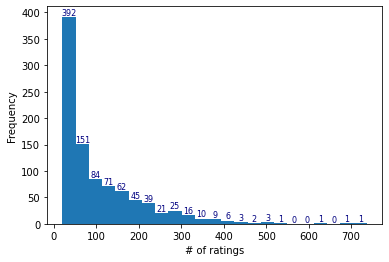

In [197]:
movie_matrix = dataPreprocessor(rating_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
temp_matrix = np.zeros(movie_matrix.shape)
temp_matrix[movie_matrix.nonzero()] = 1

count = []
for i in range(len(temp_matrix)):
  counter = temp_matrix[i,:].sum()
  count.append(counter)
values,bins,bars = plt.hist(count,bins = 23)

plt.bar_label(bars,fontsize = 8, color = 'navy')
plt.xlabel("# of ratings")
plt.ylabel("Frequency")
plt.show()



### (b)

In [219]:
movie_matrix = dataPreprocessor(rating_df, len(rating_df.userID.unique()), len(rating_df.itemID.unique()))
temp_matrix = np.zeros(movie_matrix.shape)
temp_matrix[movie_matrix.nonzero()] = 1
tau = 170
count = np.array(count)
train_above = movie_matrix[count >= tau]
train_below = movie_matrix[count < tau]



In [220]:
def Q6(train_matrix,base):

  if base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
    temp_matrix = np.zeros(train_matrix.shape)
    temp_matrix[train_matrix.nonzero()] = 1
    uu_similarity = 1 - pairwise_distances(train_matrix, metric = 'cosine')

          # UxI: UxU mul UxI
    normalizer = np.matmul(uu_similarity, temp_matrix)
          #print(normalizer)
    normalizer[normalizer == 0] = 1e-5
          #what's the dimension of np.matmul(uu_similarity, trainSet)
          
    predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
          #predictionMatrix[temp_matrix.nonzero()] = 0
          #Cold start
          # if no one has rated this item before, use user average  
    useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
    columns = np.sum(predictionMatrix, axis=0)
          #print(columns.shape)
    predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)

            ###########         end         ###########
            
  elif base == 'item':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
      train_matrix = np.transpose(train_matrix)   ## now becomes item-user matrix
      temp_matrix = np.zeros(train_matrix.shape)
      temp_matrix[train_matrix.nonzero()] = 1
      uu_similarity = 1 - pairwise_distances(train_matrix, metric = 'cosine') 
            # UxI: UxU mul UxI
      normalizer = np.matmul(uu_similarity, temp_matrix)
            # print(normalizer)
      normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            
      predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            # if no one has rated this item before, use user average  
      useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 0.00000001) 
      columns = np.sum(predictionMatrix, axis=0)
            # print(columns.shape)
      predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
      predictionMatrix = predictionMatrix.T 


            ###########         end         ###########
  else:
    print('No other option available')
  return predictionMatrix

In [221]:
above_user = Q6(train_above, base = 'user')
below_user = Q6(train_below, base = 'user')

above_item = Q6(train_above, base = 'item')
below_item = Q6(train_below, base = 'item')

In [222]:
predicted_above = above_user[train_above.nonzero()]
gd_true_above = train_above[train_above.nonzero()]
rmse_above = mean_squared_error(predicted_above, gd_true_above)
print("With above Threshold(user):",rmse_above)

predicted_below = below_user[train_below.nonzero()]
gd_true_below = train_below[train_below.nonzero()]
rmse_below = mean_squared_error(predicted_below, gd_true_below)
print("With below Threshold(user):",rmse_below)


predicted_above = above_item[train_above.nonzero()]
gd_true_above = train_above[train_above.nonzero()]
rmse_above = mean_squared_error(predicted_above, gd_true_above)
print("With above Threshold(item):",rmse_above)

predicted_below = below_item[train_below.nonzero()]
gd_true_below = train_below[train_below.nonzero()]
rmse_below = mean_squared_error(predicted_below, gd_true_below)
print("With below Threshold(item):",rmse_below)



With above Threshold(user): 0.8780486304117067
With below Threshold(user): 0.8565769805873762
With above Threshold(item): 1.0080075621522704
With below Threshold(item): 0.8661539342645661


**ANSWER:**
recommadtion performs generally better on user based method.Below threshold performs better than higher than threshold because below threshold has more rating.

# Validation

In [202]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [203]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [204]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [205]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [206]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [207]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [208]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [209]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [210]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [211]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [212]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [213]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [214]:
validateUUSimBasedRecSys()

<ipython-input-170-68a087716955>:95: RuntimeWarning: invalid value encountered in true_divide
  useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)


### Item-Item Similarity Based Recommendation System

In [215]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        item_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        item_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = item_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [216]:
validateIISimBasedRecSys()